In [2]:
import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

### Setting up hyperparameters

In [3]:
num_epochs = 20
batch_size = 512
random_seed = 42
embedding_dim = 64
hidden_dim = 300
num_classes = 2
learning_rate = 0.005

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [4]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.mps.manual_seed(random_seed)

In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Deleting unneeded columns, renaming headers and maping labels to numbers

In [6]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.columns = ['LABEL', 'TEXT']
df['LABEL'] = df['LABEL'].map({'ham': 0, 'spam': 1})

In [7]:
df.head()

,LABEL,TEXT
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Checking for null values

In [8]:
df.isnull().sum()

LABEL    0
TEXT     0
dtype: int64

### Checking if there's imbalance in the data

LABEL
0    4825
1     747
Name: count, dtype: int64

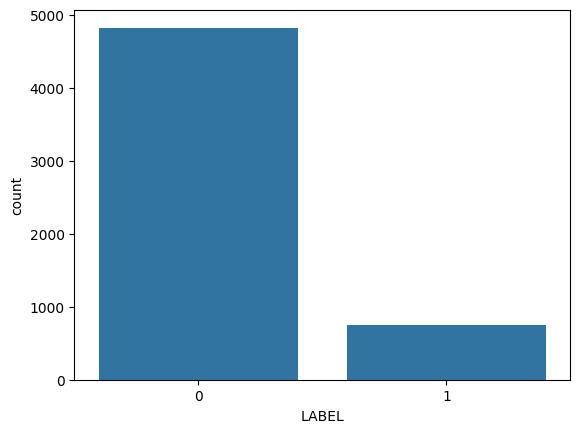

In [9]:
sns.countplot(data=df, x='LABEL')
df['LABEL'].value_counts()

### I'll use stratied sampling to preserve the retio of the class labels

In [10]:
X = df['TEXT']
y = df['LABEL']
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Let's deal with the imbalance using class weights

In [11]:
def calculate_class_weights(classes):
    num_classes = classes.nunique()
    num_examples = classes.shape[0]
    counts = classes.value_counts().tolist()
    class_weights = [num_examples / (freq * num_classes) for freq in counts]
    class_weights = torch.tensor(class_weights)
    return class_weights

class_weights = calculate_class_weights(train_labels)

### Specifing the tokenizer and building the vocabulary from the training data to prevent data leakage

In [12]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_texts), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
len(vocab)

10223

### Building our dataset to pass to the dataloader

In [13]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        text = self.tokenizer(text)
        text = self.vocab(text)
        text = torch.tensor(text, dtype=torch.long)
        torch.tensor(label, dtype=torch.long)
        return text, label

    def __len__(self):
        return len(self.texts)

In [14]:
train_data = MyDataset(train_texts, train_labels, vocab, tokenizer)
test_data = MyDataset(test_texts, test_labels, vocab, tokenizer)

#### creating the collate function ourselves to fix the sequence length accross the batches

In [15]:
def collate(batch):
    labels = torch.tensor([i[1] for i in batch], dtype=torch.long)
    texts = [i[0] for i in batch]
    text_lengths = torch.tensor([len(t) for t in texts])
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    return texts, text_lengths, labels

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

#### Now, we build the model class and we're gonna be using 2 stacked LSTMs, unidirectional

In [16]:
class LSTM_MODEL(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2, num_layers=2):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,
                                                            lengths,
                                                            batch_first=True,
                                                            enforce_sorted=False)
        
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        hidden = hidden[-1]
        return self.fc(hidden)

### Initializing the model, loss function and the optimizer

In [17]:
model = LSTM_MODEL(len(vocab), embedding_dim, hidden_dim)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [18]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for texts, lengths, labels in train_loader:
        optimizer.zero_grad()
        logits = model(texts, lengths)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch: {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}')

Epoch: 1/20 | Loss: 5.3282
Epoch: 2/20 | Loss: 2.7201
Epoch: 3/20 | Loss: 1.9023
Epoch: 4/20 | Loss: 1.3517
Epoch: 5/20 | Loss: 1.0362
Epoch: 6/20 | Loss: 0.8061
Epoch: 7/20 | Loss: 0.6102
Epoch: 8/20 | Loss: 0.4673
Epoch: 9/20 | Loss: 0.3630
Epoch: 10/20 | Loss: 0.3302
Epoch: 11/20 | Loss: 0.2424
Epoch: 12/20 | Loss: 0.1570
Epoch: 13/20 | Loss: 0.0891
Epoch: 14/20 | Loss: 0.0606
Epoch: 15/20 | Loss: 0.0264
Epoch: 16/20 | Loss: 0.0219
Epoch: 17/20 | Loss: 0.0159
Epoch: 18/20 | Loss: 0.0128
Epoch: 19/20 | Loss: 0.0132
Epoch: 20/20 | Loss: 0.0085


# Evaluation

In [19]:
model.eval()
num_correct_predictions, num_examples = 0, 0
with torch.no_grad():
    for texts, lengths, labels in test_loader:
        outputs = model(texts, lengths)
        predictions = outputs.argmax(dim=1)
        num_examples += labels.size(0)
        num_correct_predictions += (predictions == labels).sum().item()
print(f"Accuracy: {(num_correct_predictions / num_examples) * 100:.2f}%")

Accuracy: 97.31%


### Now, we save the model

In [21]:
torch.save(model.state_dict(), 'saved_spam_detection/model_saved_spam_detection.pt')
torch.save(optimizer.state_dict(), 'saved_spam_detection/optimizer_saved_spam_detection.pt')

#### Prediction funtion: it'll output the predicted class label with a probability associated with it.

In [22]:
def predict_sentiment(text, model, tokenizer, vocab):
    tokens = tokenizer(text)
    stoi = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(stoi)])
    tensor = torch.LongTensor(stoi).unsqueeze(dim=0)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

### Picking 20 sentences with label 1 from test data to check whether the model is able to deal with imbalance

In [23]:
ones = []
for idx, value in enumerate(test_labels):
    if value == 1:
        ones.append(idx)
    if len(ones) == 20:
        break

In [24]:
for idx in ones:
    print(predict_sentiment(test_texts.iloc[idx], model, tokenizer, vocab))

(1, 0.9999902248382568)
(1, 0.9980766773223877)
(1, 0.9999988079071045)
(1, 0.9996176958084106)
(0, 0.9919806718826294)
(1, 0.9999994039535522)
(1, 0.9999988079071045)
(1, 0.9999991655349731)
(1, 0.9999996423721313)
(1, 0.9999995231628418)
(1, 0.9996552467346191)
(1, 0.9999786615371704)
(0, 0.9998904466629028)
(1, 0.9999886751174927)
(1, 0.9999951124191284)
(1, 0.999992847442627)
(1, 0.9999563694000244)
(1, 0.8232138752937317)
(1, 0.9999979734420776)
(0, 0.987557053565979)
